In [1]:


%matplotlib inline

import gzip
import pickle
from urllib.request import urlretrieve
import zipfile

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl



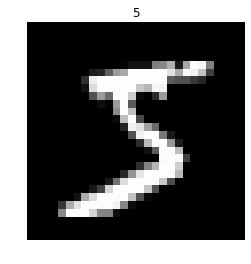

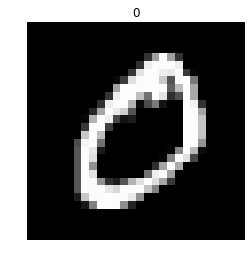

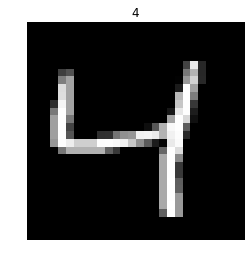

In [2]:
urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", 
            "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz") as f:
    train_data, _, test_data = pickle.load(f, encoding="latin1")
train_data = list(train_data)
test_data = list(test_data)
for data in (train_data, test_data):
    one_hot = np.zeros((data[0].shape[0], 10))
    one_hot[np.arange(data[0].shape[0]), data[1]] = 1
    data[1] = one_hot

for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_data[0][i], (28, 28)),
               cmap="gray")
    plt.axis('off')
    plt.title(str(np.argmax(train_data[1][i])));

In [3]:
with nengo.Network() as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    neuron_type = nengo.LIF(amplitude=0.01)
    
    # we'll make all the nengo objects in the network
    # non-trainable. we could train them if we wanted, but they don't
    # add any representational power. note that this doesn't affect 
    # the internal components of tensornodes, which will always be 
    # trainable or non-trainable depending on the code written in 
    # the tensornode.
    nengo_dl.configure_settings(trainable=False)

    # the input node that will be used to feed in input images 
    inp = nengo.Node([0] * 28 * 28)

    # add the first convolutional layer
    x = nengo_dl.tensor_layer(
        inp, tf.layers.conv2d, shape_in=(28, 28, 1), filters=32,
        kernel_size=3)

    # apply the neural nonlinearity
    x = nengo_dl.tensor_layer(x, neuron_type)

    # add another convolutional layer
    x = nengo_dl.tensor_layer(
        x, tf.layers.conv2d, shape_in=(26, 26, 32), 
        filters=64, kernel_size=3)
    x = nengo_dl.tensor_layer(x, neuron_type)

    # add a pooling layer
    x = nengo_dl.tensor_layer(
        x, tf.layers.average_pooling2d, shape_in=(24, 24, 64),
        pool_size=2, strides=2)

    # another convolutional layer
    x = nengo_dl.tensor_layer(
        x, tf.layers.conv2d, shape_in=(12, 12, 64),
        filters=128, kernel_size=3)
    x = nengo_dl.tensor_layer(x, neuron_type)

    # another pooling layer
    x = nengo_dl.tensor_layer(
        x, tf.layers.average_pooling2d, shape_in=(10, 10, 128),
        pool_size=2, strides=2)

    # linear readout
    x = nengo_dl.tensor_layer(x, tf.layers.dense, units=10)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(x)
    out_p_filt = nengo.Probe(x, synapse=0.1)

In [4]:


minibatch_size = 200
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)



Build finished in 0:00:00                                                      
Optimization finished in 0:00:01                                               
Construction finished in 0:00:01                                               #########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [6]:
# add the single timestep to the training data
train_data = {inp: train_data[0][:, None, :],
              out_p: train_data[1][:, None, :]}

# when testing our network with spiking neurons we will need to run it 
# over time, so we repeat the input/target data for a number of 
# timesteps. we're also going to reduce the number of test images, just 
# to speed up this example.
n_steps = 30
test_data = {
    inp: np.tile(test_data[0][:minibatch_size*2, None, :],
                 (1, n_steps, 1)),
    out_p_filt: np.tile(test_data[1][:minibatch_size*2, None, :],
                        (1, n_steps, 1))}



In [7]:
def objective(outputs, targets): 
    return tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=outputs, labels=targets)

In [8]:
opt = tf.train.RMSPropOptimizer(learning_rate=0.001)

In [9]:
def classification_error(outputs, targets):
    return 100 * tf.reduce_mean(
        tf.cast(tf.not_equal(tf.argmax(outputs[:, -1], axis=-1), 
                             tf.argmax(targets[:, -1], axis=-1)),
                tf.float32))


print("error before training: %.2f%%" % sim.loss(
    test_data, {out_p_filt: classification_error}))

Calculation finished in 0:00:22                                                
error before training: 89.00%


In [10]:
do_training = True
if do_training:
    # run training
    sim.train(train_data, opt, objective={out_p: objective}, n_epochs=10)
    
    # save the parameters to file
    sim.save_params("./mnist_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1u9JyNuRxQDUcFgkRnI1qfJVFMdnGRsjI", 
        "mnist_params.zip")
    with zipfile.ZipFile("mnist_params.zip") as f:
        f.extractall()
        
    # load parameters
    sim.load_params("./mnist_params")





Training finished in 0:10:54 (loss: 1.8438)                                    


In [11]:
print("error after training: %.2f%%" % sim.loss(
    test_data, {out_p_filt: classification_error}))

Calculation finished in 0:00:07                                                
error after training: 1.00%


Simulation finished in 0:00:04                                                 


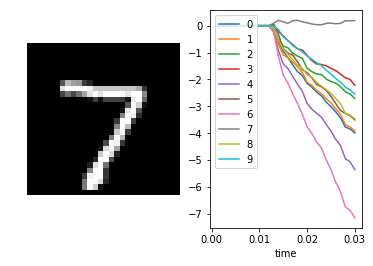

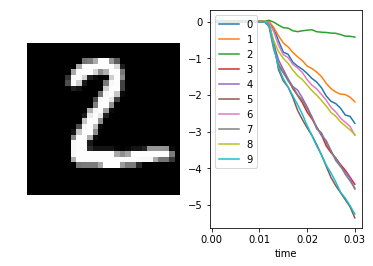

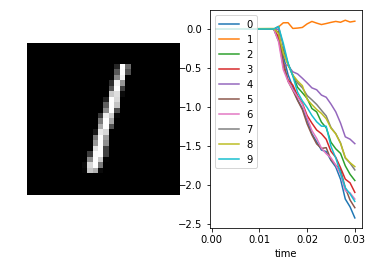

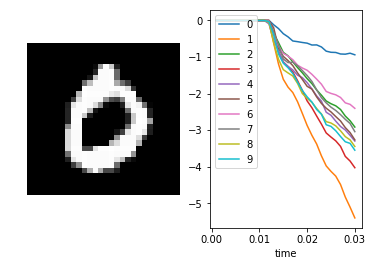

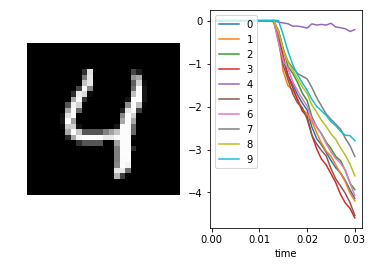

In [12]:
sim.run_steps(n_steps, data={inp: test_data[inp][:minibatch_size]})

for i in range(5):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(test_data[inp][i, 0], (28, 28)),
               cmap="gray")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(sim.trange(), sim.data[out_p_filt][i])
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("time")